In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import re
import pickle
from liftover import get_lifter
import seaborn as sns
sys.path.append("/home/yanhu/DddA/DddA/tdac_seq")
from ddda_dataset import *
%matplotlib inline

In [2]:
# Create a dictionary for reference regions
ref_range_dict = {
    'LCR': ('chr11', 5279265, 5282582)
}

# Initialize ddda_dataset
ddda_data = ddda_dataset(
    ID = "HJR_239_cr15_2hr_HS2", 
    region_dict = ref_range_dict, 
    genome_file = "/home/yanhu/data/DddA/shared/refGenomes/hg38.fa", 
    fastq_file = "/home/yanhu/data/DddA/HJR239/HJR239_cr15_2hr_HS2/HJR239_cr15_2hr_HS2.fastq.gz", 
    working_dir = "/home/yanhu/data/DddA/HJR239/HJR239_cr15_2hr_HS2/"
)

# Load DddA bias model
with open("/home/yanhu/data/DddA/HJR245/bias_dict.pkl", "rb") as f:
    ddda_data.bias_model = pickle.load(f)

# Align reads
start_gap_threshold = 500
end_gap_threshold = 500
ddda_data.align_reads(
    start_gap_threshold = start_gap_threshold,
    end_gap_threshold = end_gap_threshold,
)

# Position of the sgRNA
sgRNA_start, sgRNA_end = 5280748, 5280767
sgRNA_start = sgRNA_start - ref_range_dict["LCR"][1] + 1
sgRNA_end = sgRNA_end - ref_range_dict["LCR"][1] + 1

Loading reference genome
Extracting sequences for each locus
Computing sequence bias


100%|██████████████████████████████████████████████████████████████████| 18682/18682 [00:04<00:00, 3792.21it/s]


14528 reads aligned. 4154 reads unaligned


In [3]:
# Compute a read-by-position matrix of deletion labels
locus = "LCR"
total_del_size = np.array(np.sum(ddda_data.del_dict[locus], axis=1))[:, 0]

# Identify reads where the CTCF motif is deleted
deletion_flag = np.max(np.array(ddda_data.del_dict[locus][:, sgRNA_start:(sgRNA_end + 1)].todense()), axis = 1) 

/home/yanhu/utils/miniforge3/envs/DddA/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


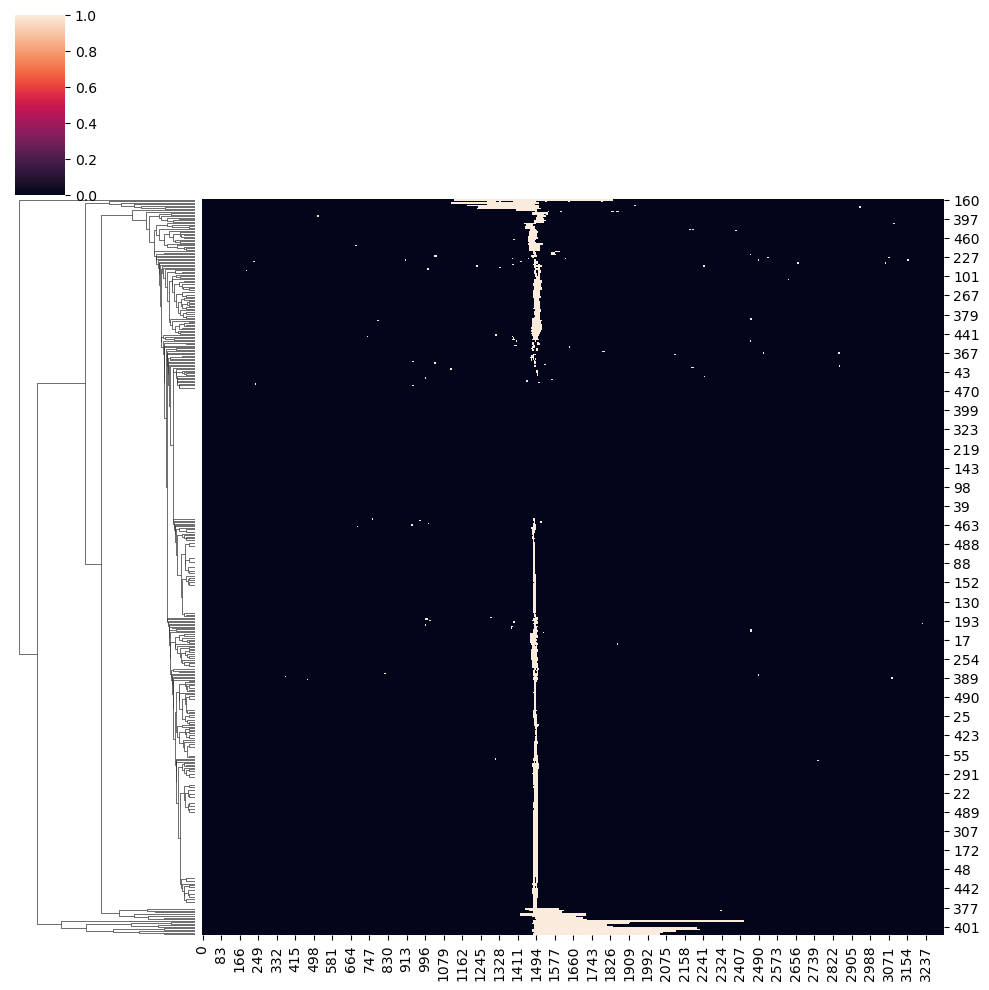

In [4]:
sns.clustermap(np.array(ddda_data.del_dict[locus][500:1000,:].todense()), col_cluster=False)

In [5]:
# Select reads to run footprinting on
selected_reads = []
selected_del_flags = []
for read_ind in range(len(ddda_data.read_ids[locus])):

    # Skip reads with large deletions
    if total_del_size[read_ind] > 100:
        continue

    # Select reads with high editing rates 
    if np.sum(ddda_data.edit_dict[locus][read_ind]) > 20:
        read_id = ddda_data.read_ids[locus][read_ind]
        selected_reads.append(read_id)
        selected_del_flags.append(deletion_flag[read_ind])
selection_dict = {"LCR":selected_reads}
selected_del_flags = np.array(selected_del_flags)

In [6]:
footprints_dict = ddda_data.get_footprints(selection_dict, footprint_radii = [50],
                                          combine_sides="max_pval")

Computing footprints for LCR


100%|█████████████████████████████████████████████████████████████████████| 6526/6526 [00:11<00:00, 572.79it/s]


<Figure size 1280x960 with 0 Axes>

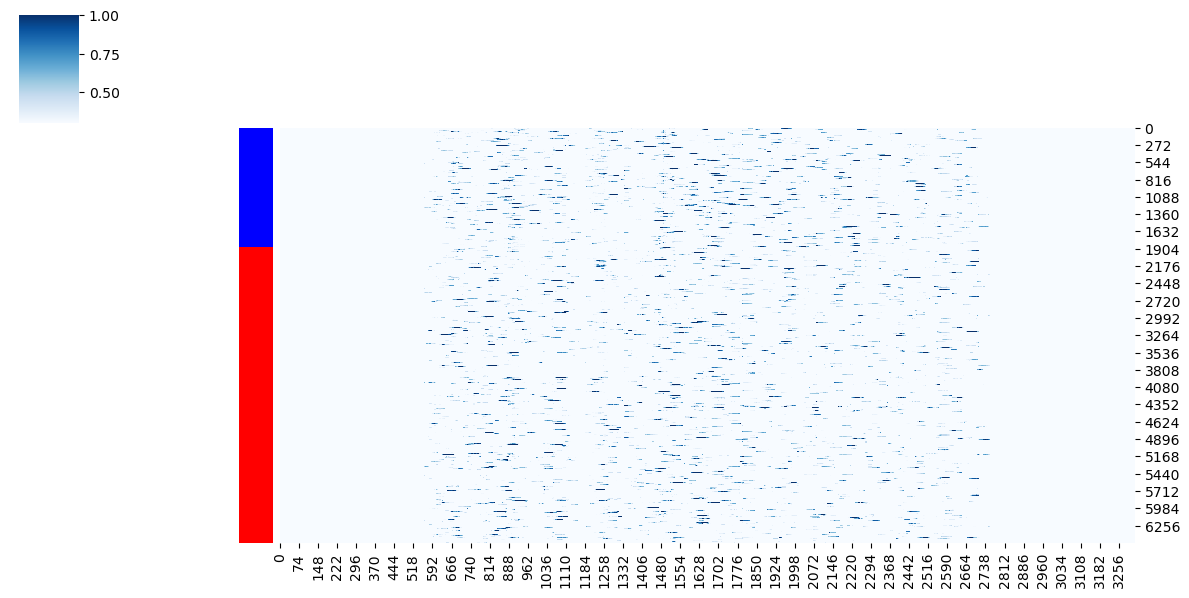

In [7]:
locus = 'LCR'
fp = np.squeeze(np.array([i for i in footprints_dict[locus].values()]))
fp = -np.log10(fp)
row_order = np.argsort(selected_del_flags)
plt.figure(dpi=200)
sns.clustermap(
    fp[row_order, :], col_cluster=False, row_cluster=False, vmax = 1, vmin = 0.3, 
    cmap="Blues", figsize=(12, 6), 
    row_colors = ["Red" if i == 1 else "Blue" for i in np.array(selected_del_flags)[row_order]])

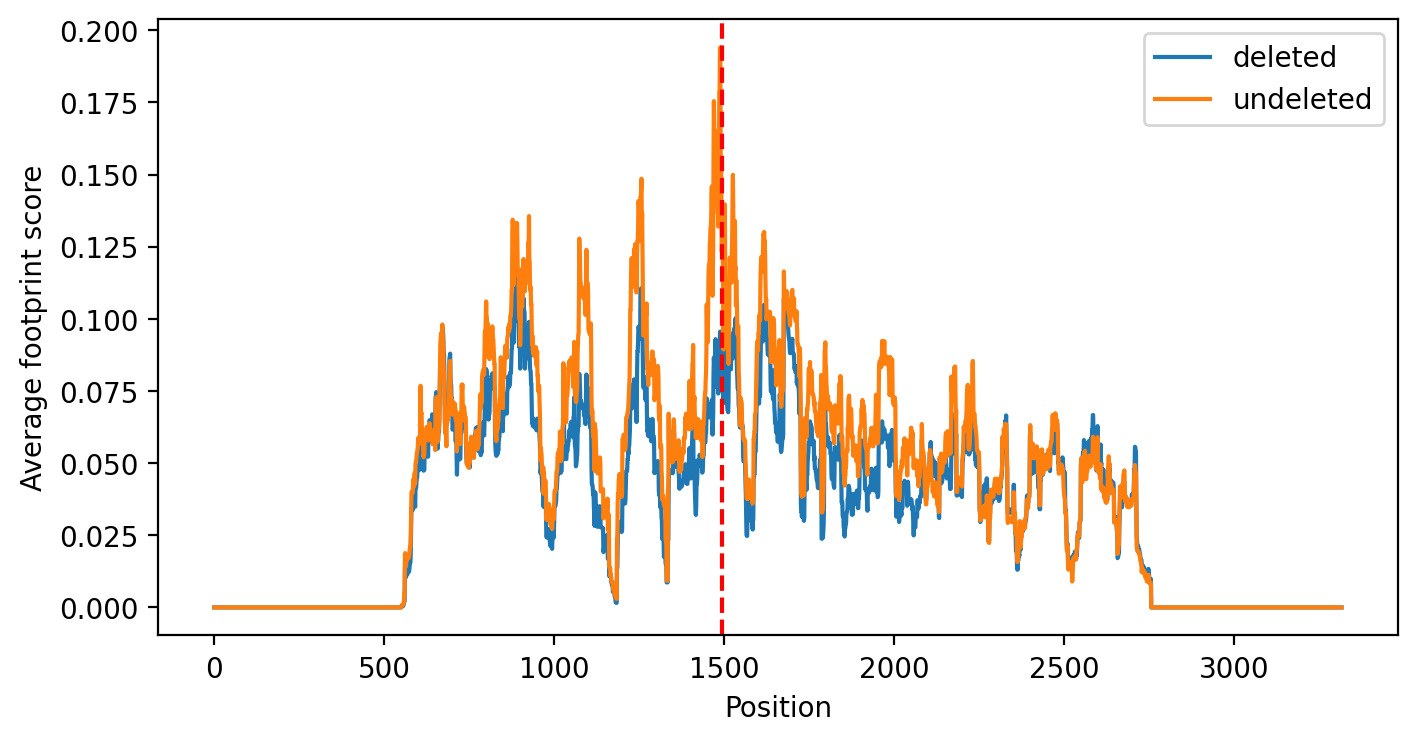

In [8]:
track_deleted = np.mean(fp[np.array(selected_del_flags) == 1, :], axis = 0)
track_undeleted = np.mean(fp[np.array(selected_del_flags) == 0, :], axis = 0)
plt.figure(dpi=200, figsize=(8, 4))
plt.plot(np.arange(len(track_deleted)), track_deleted, label="deleted")
plt.plot(np.arange(len(track_undeleted)), track_undeleted, label="undeleted")
plt.axvline(ymin=0, ymax=1, x = (sgRNA_start + sgRNA_end) / 2, color="red", linestyle="dashed")
plt.xlabel("Position")
plt.ylabel("Average footprint score")
plt.legend()
plt.show()

In [9]:
from scipy.stats import ttest_ind
pvals = []
diff_mean = []
for i in range(np.shape(fp)[1]):
    del_scores = fp[np.array(selected_del_flags) == 1, i]
    undel_scores = fp[np.array(selected_del_flags) == 0, i]
    diff_mean.append(np.mean(del_scores) - np.mean(undel_scores))
    pvals.append(ttest_ind(del_scores, undel_scores).pvalue)
pvals = np.array(pvals)
diff_mean = np.array(diff_mean)

# Mask positions that are potentially not covered by some reads
pvals[:start_gap_threshold] = 1
pvals[-end_gap_threshold:] = 1

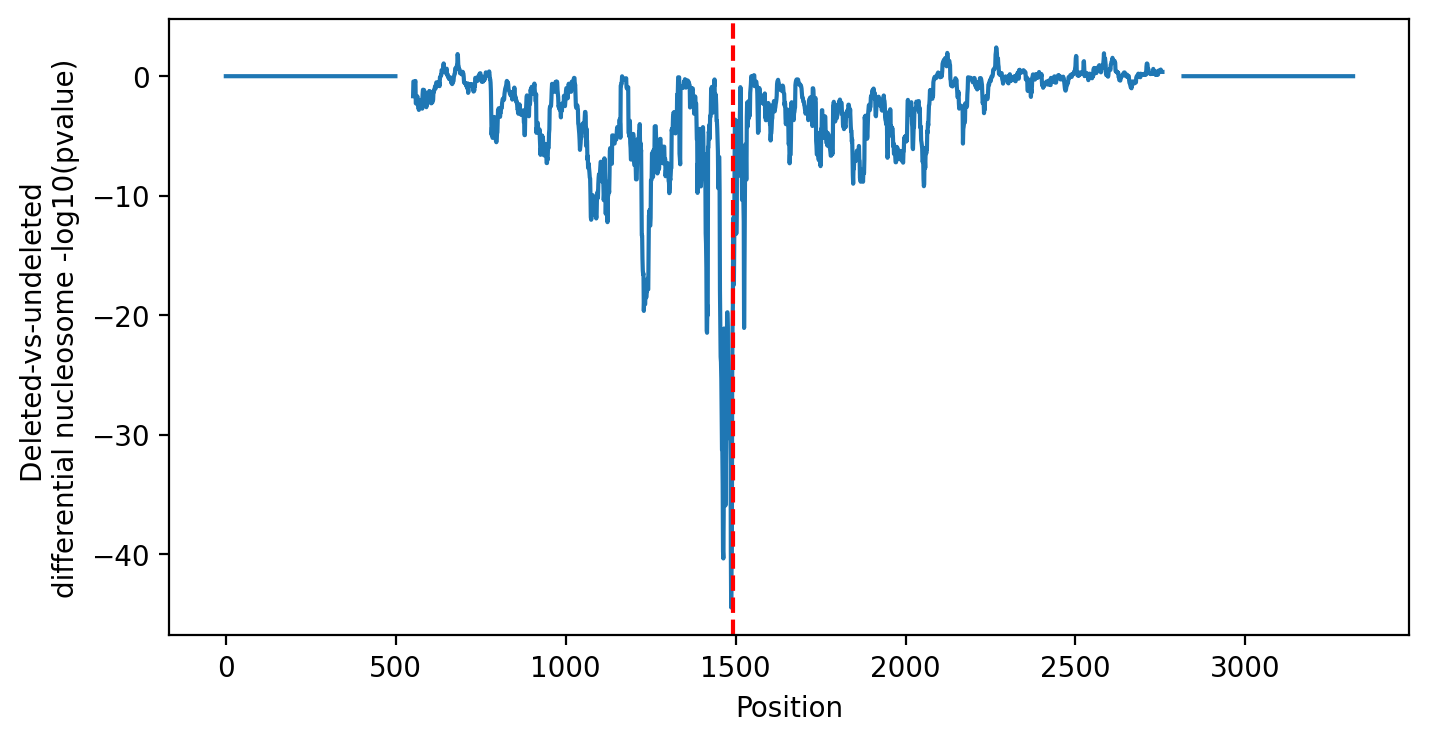

In [10]:
# Visualize results
plt.figure(dpi=200, figsize=(8, 4))
plt.plot(np.arange(len(pvals)), -np.log10(pvals) * np.sign(diff_mean))
plt.axvline(ymin=0, ymax=1, x = (sgRNA_start + sgRNA_end) / 2, color="red", linestyle="dashed")
plt.xlabel("Position")
plt.ylabel("Deleted-vs-undeleted \ndifferential nucleosome -log10(pvalue)")
plt.show()

### Examine editing rate (accessibility)

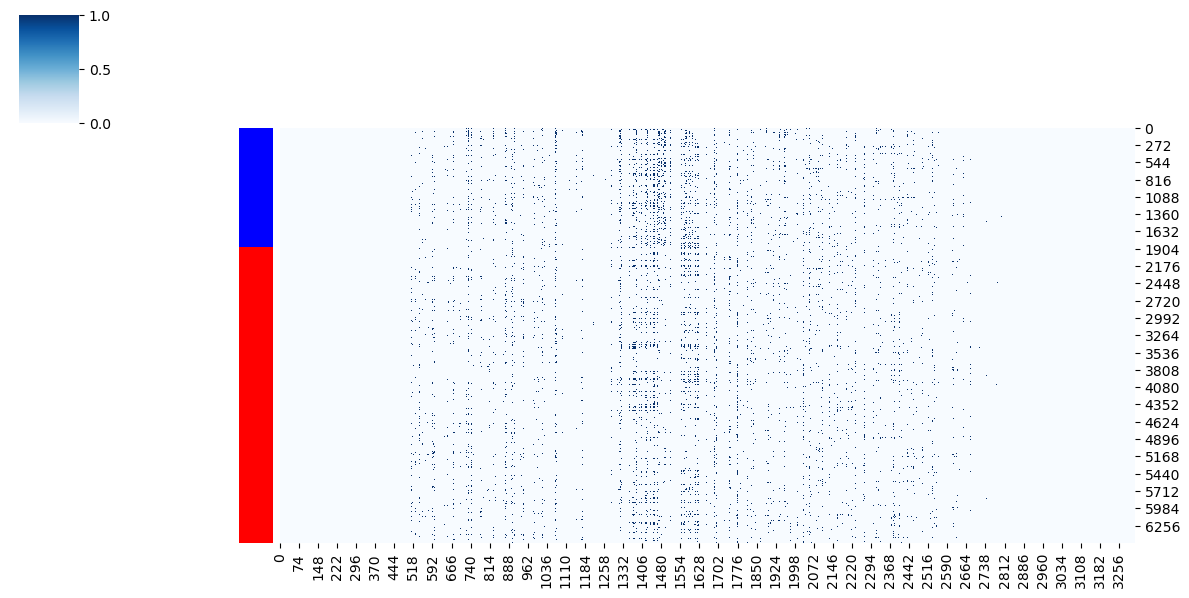

In [11]:
selected_inds = [ddda_data.read_ids[locus].index(i) for i in selection_dict[locus]]
edits = np.array(ddda_data.edit_dict[locus][selected_inds, :].todense())
row_order = np.argsort(selected_del_flags)
sns.clustermap(
    edits[row_order, :], col_cluster=False, row_cluster=False,
    cmap="Blues", figsize=(12, 6), 
    row_colors = ["Red" if i == 1 else "Blue" for i in np.array(selected_del_flags)[row_order]])

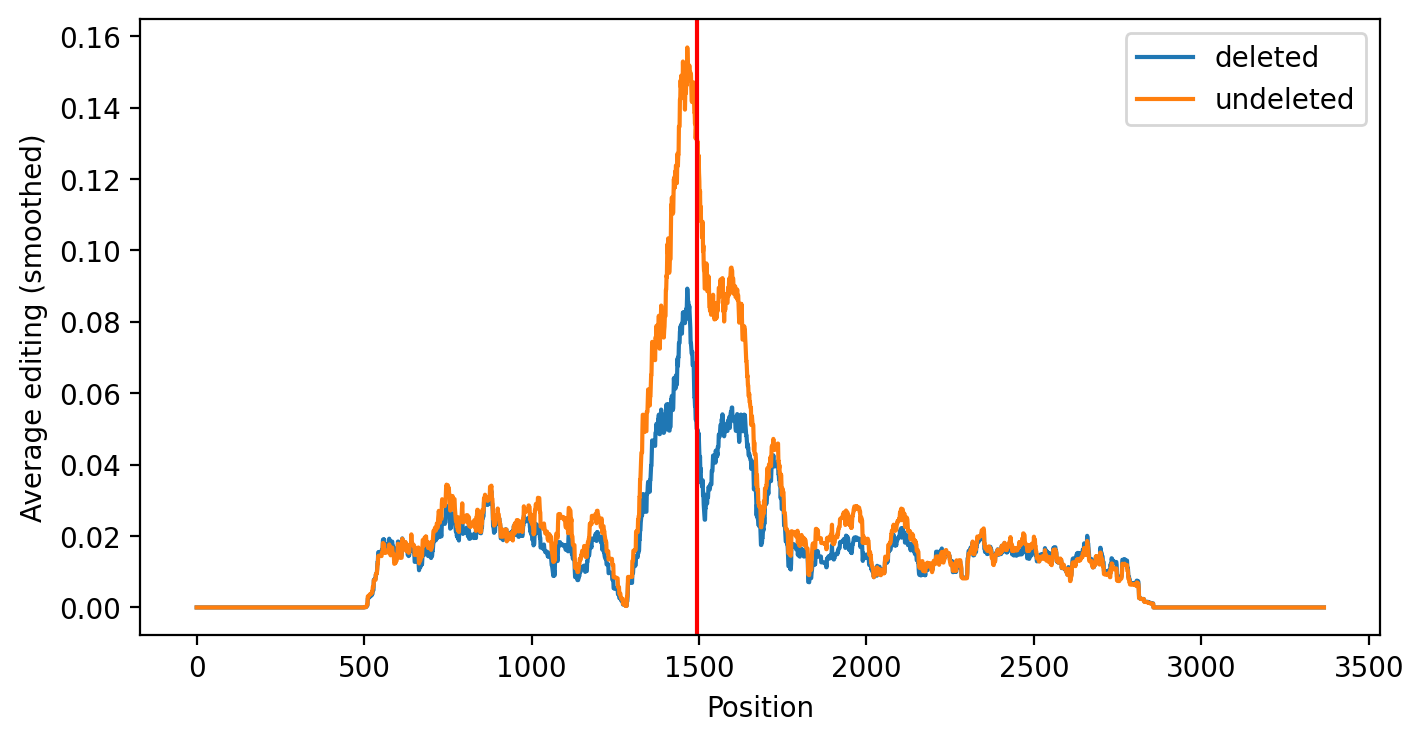

In [12]:
# Calculate average editing rate for each condition
track_deleted = np.mean(edits[np.array(selected_del_flags) == 1, :], axis = 0)
track_undeleted = np.mean(edits[np.array(selected_del_flags) == 0, :], axis = 0)

# Smooth tracks
track_deleted = np.convolve(track_deleted, np.ones(50))/50
track_undeleted = np.convolve(track_undeleted, np.ones(50))/50

# Visualize results
plt.figure(dpi=200, figsize=(8, 4))
plt.plot(np.arange(len(track_deleted)), track_deleted, label="deleted")
plt.plot(np.arange(len(track_undeleted)), track_undeleted, label="undeleted")
plt.axvline(ymin=0, ymax=1, x = (sgRNA_start + sgRNA_end) / 2, color = "Red")
plt.xlabel("Position")
plt.ylabel("Average editing (smoothed)")
plt.legend()
plt.show()

### First group reads into pseudo-bulks and then calculate footprints

In [13]:
# Find reads where the sgRNA target site is covered by a deletion
del_start, del_end = sgRNA_start, sgRNA_end
del_matrix = np.array(ddda_data.del_dict[locus].todense())
del_read_inds = np.where(np.max(del_matrix[:, del_start:del_end], axis=1) == 1)[0]

# Only keep reads where positions outside of the vicinity of the sgRNA target site are not deleted
upstream_filter = np.max(del_matrix[:,:del_start], axis=1) == 0
downstream_filter = np.max(del_matrix[:,del_end:], axis=1) == 0
filter = np.where(upstream_filter & downstream_filter)[0]
del_read_inds = np.intersect1d(del_read_inds, filter)

# Separately, also find reads without any deletion as a control
undel_read_inds = np.where(np.max(del_matrix, axis=1) == 0)[0]

# Down-sample the number of reads
min_num = min(len(del_read_inds), len(undel_read_inds))
del_read_inds = np.random.choice(del_read_inds, min_num, replace=False)
undel_read_inds = np.random.choice(undel_read_inds, min_num, replace=False)

results = {group:{"footprints":[], "edits":[]} for group in ["deleted", "undeleted"]}
for mode in ["undeleted", "deleted"]:

    # Select reads with or without deletion
    if mode == "deleted":
        read_inds = del_read_inds
    else: 
        read_inds = undel_read_inds

    # Divide into pseudobulks
    n_pbulk = 10
    pbulk_read_inds = np.array_split(read_inds, n_pbulk)

    # Calculate aggregate footrpints and edits per pseudo-bulk
    footprint_radii = [50]
    for pbulk_ind in tqdm(range(n_pbulk)):
    
        read_inds = pbulk_read_inds[pbulk_ind]
        agg_edits = np.array(np.sum(ddda_data.edit_dict[locus][read_inds, :], axis=0))[0, :]
    
        # Combine the edits and bias of both strands to call footprints
        strands = ddda_data.read_strands[locus][read_inds]
        C_to_T_bias = ddda_data.bias_dict[locus][:, 0]
        G_to_A_bias = ddda_data.bias_dict[locus][:, 1]
        agg_bias = C_to_T_bias * np.mean(strands == 0) + G_to_A_bias * np.mean(strands == 1) # Weight both strands
        
        # We mask the vicinity of the guide since the deletions might affect footprint calling
        agg_edits[del_start:del_end] = 0
        agg_bias[del_start:del_end] = 0
        
        # Calculate footprints
        footprints = np.array([get_footprint_single_scale(
            agg_edits, agg_bias, fp_radius=r, combine_sides="max_pval") for r in footprint_radii])
        footprints = -np.log10(footprints + 1e-300)

        # Combine forward strand an reverse strand results
        results[mode]["footprints"].append(footprints)
        results[mode]["edits"].append(agg_edits)
    
    results[mode]["footprints"] = np.squeeze(np.array(results[mode]["footprints"]))
    results[mode]["edits"] = np.array(results[mode]["edits"])

100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 300.74it/s]


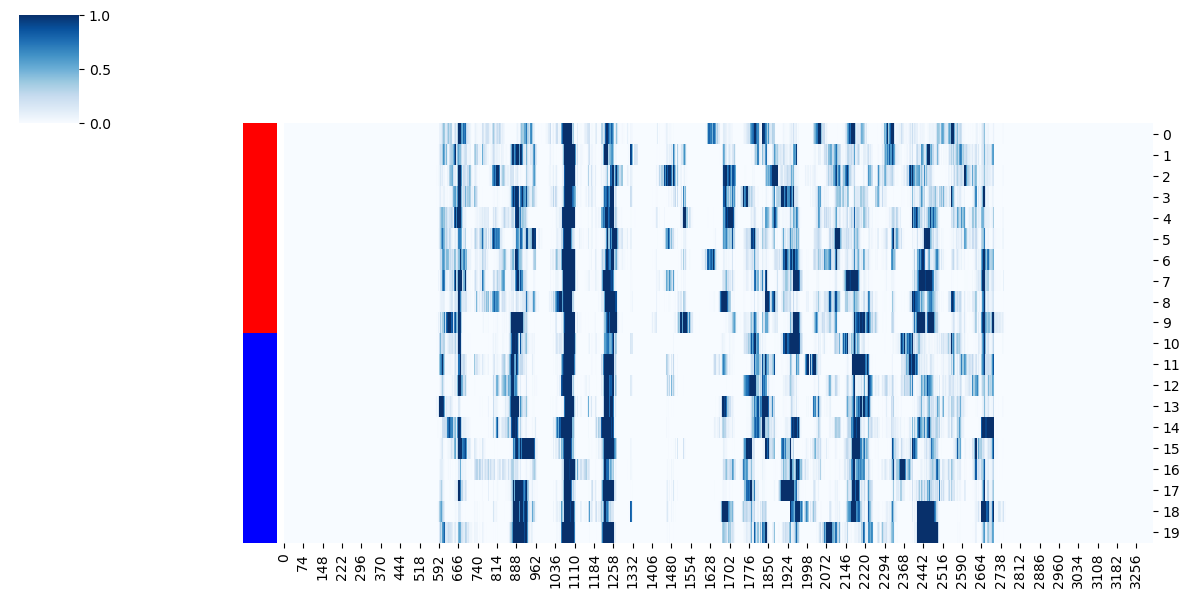

In [14]:
edit_matrix = np.concatenate(
 [results["deleted"]["footprints"],
 results["undeleted"]["footprints"]])
sns.clustermap(
    edit_matrix, col_cluster=False, row_cluster=False, 
    cmap="Blues", figsize=(12, 6), 
    row_colors = ["red" for i in range(n_pbulk)] + 
    ["blue" for i in range(n_pbulk)],
    vmax=1
)